In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import os
import sys
import pandas as pd
from re import split
from ast import literal_eval
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns
import numpy as np
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, progress
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import numpy as np
from re import split
from skimage.filters import gaussian, threshold_otsu
from skimage import measure
from scipy.interpolate import griddata
from scipy.spatial import cKDTree as KDTree
import matplotlib.patches as mpatches
import dask.array as da
from dask import delayed
import dask
from dask_image.ndfilters import uniform_filter as uf
from dask_image.ndmeasure import variance as varian
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.utils import get_pars_from_ini
location = split(', |_|-|!', os.popen('hostname').read())[0].replace("\n", "")
path_data = get_pars_from_ini(campaign='loc')[location]['path_data']
path_proj = get_pars_from_ini(campaign='loc')[location]['path_proj']
plt.style.use('ggplot')

In [2]:
# @jit
def get_col_row(x, size=30):
    ncols = da.ptp(x) / size
    return int(ncols)


def excluding_mesh(x, y, nx=30, ny=30):
    """
    Construct a grid of points, that are some distance away from points (x,
    """

    dx = x.ptp() / nx
    dy = y.ptp() / ny

    xp, yp = np.mgrid[x.min() - 2 * dx:x.max() + 2 * dx:(nx + 2) * 1j,
             y.min() - 2 * dy:y.max() + 2 * dy:(ny + 2) * 1j]
    xp = xp.ravel()
    yp = yp.ravel()

    tree = KDTree(np.c_[x, y])
    dist, j = tree.query(np.c_[xp, yp], k=1)

    # Select points sufficiently far away
    m = (dist > np.hypot(dx, dy))
    return xp[m], yp[m]


def regridd(data, x, y, size=30):
    """
    data = xarray datarray
    size = desired pixel size in meters
    """
    if data.ndim > 2:
        x = da.moveaxis(x.reshape(-1, x.shape[-1]), 0, -1)
        y = da.moveaxis(y.reshape(-1, y.shape[-1]), 0, -1)
        ncols_n = max(np.apply_along_axis(get_col_row, arr=x, axis=1))
        nrows_n = max(np.apply_along_axis(get_col_row, arr=y, axis=1))
        x_new_n = da.from_array(np.moveaxis(np.linspace(np.amin(x, -1), np.amax(x, -1), ncols_n), 0, -1))
        y_new_n = da.from_array(np.moveaxis(np.linspace(np.amax(y, -1), np.amin(y, -1), nrows_n), 0, -1))
        mesh = [delayed(da.meshgrid)(x_new_n[i], y_new_n[i]) for i in range(x_new_n.shape[0])]

        z_n = da.rollaxis(data.reshape(-1, data.shape[-1]), 1)
        idx_n = x.argsort(axis=-1)
        x = np.take_along_axis(x, idx_n, axis=-1)
        y = np.take_along_axis(y, idx_n, axis=-1)
        z_n = np.take_along_axis(z_n, idx_n, axis=-1)

        vp_n = dask.compute(*[delayed(excluding_mesh)(x[i], y[i]) for i in range(x.shape[0])])
        xn = [vp_n[i][0] for i in range(len(vp_n))]
        yn = [vp_n[i][1] for i in range(len(vp_n))]
        zn = dask.compute(*[delayed(da.zeros_like)(xn[i]) for i in range(x.shape[0])])
        xi_ = [mesh[i][0] for i in range(len(vp_n))]
        xi_ = dask.compute(*[da.from_delayed(v, shape=(x.shape[0], np.nan), dtype=float) for v in xi_])
        yi_ = [mesh[i][1] for i in range(len(vp_n))]
        yi_ = dask.compute(*[da.from_delayed(v, shape=(x.shape[0], np.nan), dtype=float) for v in yi_])
        zr = [delayed(griddata)((np.r_[x[i, :], xn[i]], np.r_[y[i, :], yn[i]]), np.r_[z_n[i, :], zn[i]],
                                (xi_[i], yi_[i]), method='linear', fill_value=0)
              for i in range(x.shape[0])]

        zr = da.dstack(dask.compute(*zr))
        xi_ = da.rollaxis(da.rollaxis(da.asarray(xi_), axis=-1), axis=-1)
        yi_ = da.rollaxis(da.rollaxis(da.asarray(yi_), axis=-1), axis=-1)
        return zr, xi_, yi_

    else:
        x_s = x.flatten()
        y_s = y.flatten()
        data = data.compute().flatten()
        idx = x_s.argsort()
        x_s, y_s = np.take_along_axis(x_s, idx, axis=0), np.take_along_axis(y_s, idx, axis=0)
        data = np.take_along_axis(data, idx, axis=0)
        ncols = get_col_row(x=x_s, size=size)
        nrows = get_col_row(x=y_s, size=size)
        x_new = np.linspace(x_s.min(), x_s.max(), int(ncols))
        y_new = np.linspace(y_s.max(), y_s.min(), int(nrows))
        xi, yi = np.meshgrid(x_new, y_new)
        xp, yp = excluding_mesh(x_s, y_s, nx=35, ny=35)
        zp = np.nan + np.zeros_like(xp)
        z0 = griddata((np.r_[x_s, xp], np.r_[y_s, yp]), np.r_[data, zp], (xi, yi), method='linear', fill_value=-9999)
        return z0, xi, yi


def lee_filter_new(img, size, tresh=-150):
    if img.ndim == 2:
        shape = (size, size)
    else:
        shape = (size, size, 1)
    img = da.where(da.logical_or(da.isnan(img), da.equal(img, -9999)), tresh, img)
    img_mean = uf(img, shape)
    img_sqr_mean = uf(da.power(img, 2), shape)
    img_variance = img_sqr_mean - da.power(img_mean, 2)
    overall_variance = varian(img)
    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    img_output = da.where(img_output > 0, img_output, 0)
    return img_output

def process_new(zhh14, _range, azimuth, alt3d, bin_size, time):
    x = _range * bin_size.values[0] * np.sin(np.deg2rad(azimuth))  # add roll
    y = alt3d
    img_filtered = lee_filter_new(zhh14, size=3, tresh=-180)
    img, xi, yi = regridd(img_filtered, x.values, y.values)
    img = np.where(img > 0., img, 0.)
    blurred = gaussian(img, sigma=0.8)
    binary = blurred > threshold_otsu(blurred)
    labels = measure.label(binary)
    if labels.ndim > 2:
        props = [measure.regionprops(labels[:, :, i]) for i in range(labels.shape[-1])]
        _props_all = [[[j.area for j in prop], [j.perimeter for j in prop], [j.major_axis_length for j in prop],
                       [j.minor_axis_length for j in prop], [j.bbox for j in prop]] for prop in props]
        df = pd.DataFrame(data=_props_all, columns=['area', 'perimeter', 'axmax', 'axmin', 'bbox'],
                          index=pd.to_datetime(time))
        max_zhh14 = np.apply_along_axis(np.max, arr=img,  axis=0).compute()
        df['max_zhh14'] = np.apply_along_axis(np.max, arr=max_zhh14,  axis=0)
    else:
        props = measure.regionprops(labels)
        _props_all = [[[prop.area], [prop.perimeter], [prop.major_axis_length], [prop.minor_axis_length],
                       [prop.bbox]] for prop in props]
        df = pd.DataFrame(data=_props_all, columns=['area', 'perimeter', 'axmax', 'axmin', 'bbox'])
        df['max_zhh14'] = np.max(img)

    if img.ndim > 2:
        shp = img.shape[-1]
        for i in range(shp):
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 10))
            img_plot = img[:, :, i]
            ax1.pcolormesh(x.isel(time=i), y.isel(time=i), img_filtered.compute()[:, :, i], cmap='jet',
                           vmax=50, vmin=0, shading='auto')
            ax2.imshow(img_plot, aspect='auto', cmap='jet', vmax=50, vmin=0)
            ax3.pcolormesh(xi[:, :, i], yi[:, :, i], img_plot, cmap='jet',
                           vmax=50, vmin=0, shading='auto')
            for region in props[i]:
                if region.area >= 105:
                    minr, minc, maxr, maxc = region.bbox
                    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                              fill=False, edgecolor='red', linewidth=2)
                    ax2.add_patch(rect)
            plt.show()
            print('a')

    else:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 10))
        img_plot = img
        ax1.pcolormesh(x, y, img_filtered.compute(), cmap='jet', vmax=60, vmin=0, shading='auto')
        ax2.imshow(img_plot, aspect='auto', cmap='jet', vmax=60, vmin=0)
        ax3.pcolormesh(xi, yi, img_plot, cmap='jet', vmax=60, vmin=0, shading='auto')
        ax3.set_yticks(np.arange(yi.min(), yi.max(), 250))
        for region in props:
            if region.area >= 100:
                minr, minc, maxr, maxc = region.bbox
                rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                          fill=False, edgecolor='red', linewidth=2)
                ax2.add_patch(rect)
        plt.show()
        print('a')


In [3]:
cluster = SLURMCluster(queue="seseml",
                       memory='200GB',
                       cores=40,
                       processes=1,
                       walltime='23:40:00',
                       scheduler_options={'host': '172.22.179.3:7227', 'dashboard_address': ':7798'})

In [4]:
# cluster.scale(2)
cluster.adapt(maximum_jobs=4)
cluster

In [5]:
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://172.22.179.3:7798/status,
Dashboard: http://172.22.179.3:7798/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.22.179.3:7227,Workers: 0
Dashboard: http://172.22.179.3:7798/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [6]:
def correction(df):
    return [float(i) for i in df.replace("[", '').replace("]", '').split()]

In [7]:
df = pd.read_csv('../results/all_filtered_202111111947.csv')
df.rename(columns={'Unnamed: 0': 'time'}, inplace=True)
df['time'] = pd.to_datetime(df.time)
df.index = df.time
df.drop(columns='time', inplace=True)

In [8]:
df_data = df[df.columns[:8]]
df_data = df_data.applymap(correction)
df_data = df_data.merge(df.max_zhh, left_index=True, right_index=True)
df_data.columns = ['area', 'perimeter', 'min_row', 'min_col', 'max_row', 'max_col',
                   'depth', 'width', 'max_zhh']

In [9]:
times = list(df_data.index)

In [10]:
%%time
ds_xr = xr.open_zarr(f'{path_data}/zarr_rckd/KUsKAs_Wn/lores.zarr')
ds_xr = ds_xr.sel(time=~ds_xr.get_index("time").duplicated())
ds_data = ds_xr[['alt3D']].sel(time=times)


CPU times: user 744 ms, sys: 44.2 ms, total: 788 ms
Wall time: 800 ms


In [11]:
ds_elevation = ds_data.alt3D.sel(cross_track=12, range=0).to_dataframe()
df_data = df_data.merge(ds_elevation, left_index=True, right_index=True)

In [12]:
df_data = df_data.explode(['area', 'perimeter', 'min_row', 'min_col', 'max_row', 'max_col',
                           'depth', 'width',])

In [13]:
df_data.head(2)

,area,perimeter,min_row,min_col,max_row,max_col,depth,width,max_zhh,alt3d,cross_track,lat3d,lon3d,alt3D
time,,,,,,,,,,,,,,
2019-08-24 23:05:44.899800,3522.0,375.628463,204.0,190.0,257.0,306.0,113.663297,44.330907,28.932385,9309.001289,12,17.700525,118.549542,9309.001289
2019-08-24 23:05:46.749800,6811.0,406.184812,199.0,170.0,292.0,312.0,140.465556,65.6057,39.583701,9308.915433,12,17.703229,118.550230,9308.915433


In [14]:
df_2 = pd.read_csv('../results/all_filtered_202111190906_Wn_zhh14.csv')
print(df_2.shape)
df_2.rename(columns={'Unnamed: 0': 'time'}, inplace=True)
df_2['time'] = pd.to_datetime(df_2.time)
df_2.index = df_2.time
df_2.drop(columns='time', inplace=True)

df_data_2 = df_2[df_2.columns[:8]]
df_data_2 = df_data_2.applymap(correction)
df_data_2 = df_data_2.merge(df_2.max_zhh, left_index=True, right_index=True)
df_data_2.columns = ['area', 'perimeter', 'min_row', 'min_col', 'max_row', 'max_col',
                   'depth', 'width', 'max_zhh']

(13969, 918)


In [15]:
df_2

,area,perimeter,bbox-0,bbox-1,bbox-2,bbox-3,major_axis_length,minor_axis_length,max_zhh,"('num_px', 0)",...,"('tot_px', 444)","('tot_px', 445)","('tot_px', 446)","('tot_px', 447)","('tot_px', 448)","('tot_px', 449)","('tot_px', 450)","('tot_px', 451)","('tot_px', 452)","('tot_px', 453)"
time,,,,,,,,,,,,,,,,,,,,,
2019-09-14 03:22:48.249800,[59],[31.79898987],[250],[66],[259],[79],[13.35629185],[6.31961507],21.043489,0,...,201,190,178,165,152,136,119,101,77,36
2019-09-14 03:22:50.099800,[48],[28.97056275],[251],[66],[259],[78],[12.4113479],[5.51828768],18.766246,0,...,201,190,179,165,152,136,120,102,76,36
2019-09-14 03:22:51.949800,[49],[28.97056275],[251],[66],[259],[78],[12.57387658],[5.46802466],18.884633,0,...,201,190,179,165,152,136,120,102,76,36
2019-09-14 03:22:53.799800,[51],[29.79898987],[251],[65],[259],[78],[12.97921987],[5.51183249],19.683681,0,...,201,190,179,165,152,136,119,101,77,35
2019-09-14 03:22:55.649800,[50],[28.97056275],[251],[66],[259],[78],[12.76181963],[5.43617142],19.238401,0,...,201,190,179,165,152,136,119,101,77,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-05 06:40:38.149800,[25],[24.20710678],[235],[189],[237],[203],[14.7310501],[1.98094999],14.113468,0,...,200,189,177,164,150,135,117,100,75,35
2019-10-05 06:40:39.999800,[12],[10.],[236],[190],[237],[202],[13.80821012],[0.],15.005754,0,...,201,190,178,166,150,136,120,102,76,35
2019-10-05 06:40:41.849800,[10],[8.],[236],[191],[237],[201],[11.48912529],[0.],13.697400,0,...,201,189,177,165,151,136,119,101,75,36


In [16]:
times_2 = list(df_data_2.index)
len(times_2)

13969

In [17]:
%%time
ds_xr_2 = xr.open_zarr(f'{path_data}/zarr_rckd/KUsKAsWs/lores.zarr')
ds_xr_2 = ds_xr_2.sel(time=~ds_xr_2.get_index("time").duplicated())
ds_data_2 = ds_xr_2[['alt3D']].sel(time=times_2)

CPU times: user 199 ms, sys: 8.93 ms, total: 208 ms
Wall time: 209 ms


In [18]:
ds_elevation_2 = ds_data_2.alt3D.sel(cross_track=12, range=0).to_dataframe()


In [19]:
df_data_2.shape

(13969, 9)

In [20]:
df_data_2 = df_data_2.merge(ds_elevation_2, left_index=True, right_index=True)

In [21]:
df_data_2 = df_data_2.explode(['area', 'perimeter', 'min_row', 'min_col', 'max_row', 'max_col',
                           'depth', 'width',])

In [22]:
# df_multidx = df[df.columns[9:]]

In [23]:
df_data = pd.concat([df_data, df_data_2])

In [24]:
# cols = (literal_eval(i) for i in df_multidx.columns)
# df_multidx.columns = pd.MultiIndex.from_tuples(cols)

In [25]:
df_data = df_data.astype({'area': float, 'perimeter': float, 'depth': float, 'width': float, 'min_row': float, 
                'min_col': float, 'max_row': float, 'max_col': float})

In [26]:
df_data.dtypes

area           float64
perimeter      float64
min_row        float64
min_col        float64
max_row        float64
max_col        float64
depth          float64
width          float64
max_zhh        float64
alt3d          float64
cross_track      int64
lat3d          float64
lon3d          float64
alt3D          float64
dtype: object

## initial filters

In [27]:
df_data = df_data[df_data.area > 105]
df_data = df_data[df_data.width > 0]
df_data = df_data[df_data.depth > 0]

In [28]:
df_data['min_row'] = df_data['min_row'] * 30 / 1000
df_data['max_row'] = df_data['max_row'] * 30 / 1000
df_data['min_col'] = df_data['min_col'] * 30 / 1000
df_data['max_col'] = df_data['max_col'] * 30 / 1000
df_data['area_km2'] = df_data.area * 30 ** 2 / 1000**2
df_data['perimeter_km'] = df_data.perimeter * 30 / 1000 
df_data['depth_km'] = df_data.depth * 30 / 1000 
df_data['width_km'] = df_data.width * 30 / 1000 


In [29]:
df_data.head(2)

,area,perimeter,min_row,min_col,max_row,max_col,depth,width,max_zhh,alt3d,cross_track,lat3d,lon3d,alt3D,area_km2,perimeter_km,depth_km,width_km
time,,,,,,,,,,,,,,,,,,
2019-08-24 23:05:44.899800,3522.0,375.628463,6.12,5.7,7.71,9.18,113.663297,44.330907,28.932385,9309.001289,12,17.700525,118.549542,9309.001289,3.1698,11.268854,3.409899,1.329927
2019-08-24 23:05:46.749800,6811.0,406.184812,5.97,5.1,8.76,9.36,140.465556,65.605700,39.583701,9308.915433,12,17.703229,118.550230,9308.915433,6.1299,12.185544,4.213967,1.968171


In [30]:
df_data['cloud_top'] =  df_data['alt3D'] / 1000 - df_data['min_row'] 
df_data['cloud_base'] =  df_data['alt3D'] / 1000 - df_data['max_row'] 
df_data['axis_ratio'] = df_data['depth'] / df_data['width']
df_data['axis_ratio_inv'] = df_data['width'] /df_data['depth'] 

In [31]:
df_data['day'] = pd.to_datetime(df_data.index.strftime('%Y-%m-%d'))

In [32]:
df_day = df_data.groupby(df_data.index.floor('d'))
flights = list(df_day.groups.keys())
dict_flights = {f'RF{i + 1:02d}':flights[i] for i in range(len(flights)) }
dict_fl = {flights[i]:f'RF{i + 1:02d}' for i in range(len(flights)) }

In [33]:
dict_fl

{Timestamp('2019-08-24 00:00:00'): 'RF01',
 Timestamp('2019-08-25 00:00:00'): 'RF02',
 Timestamp('2019-08-27 00:00:00'): 'RF03',
 Timestamp('2019-08-29 00:00:00'): 'RF04',
 Timestamp('2019-08-30 00:00:00'): 'RF05',
 Timestamp('2019-09-07 00:00:00'): 'RF06',
 Timestamp('2019-09-09 00:00:00'): 'RF07',
 Timestamp('2019-09-14 00:00:00'): 'RF08',
 Timestamp('2019-09-15 00:00:00'): 'RF09',
 Timestamp('2019-09-16 00:00:00'): 'RF10',
 Timestamp('2019-09-17 00:00:00'): 'RF11',
 Timestamp('2019-09-19 00:00:00'): 'RF12',
 Timestamp('2019-09-20 00:00:00'): 'RF13',
 Timestamp('2019-09-21 00:00:00'): 'RF14',
 Timestamp('2019-09-22 00:00:00'): 'RF15',
 Timestamp('2019-09-24 00:00:00'): 'RF16',
 Timestamp('2019-09-25 00:00:00'): 'RF17',
 Timestamp('2019-09-27 00:00:00'): 'RF18',
 Timestamp('2019-09-28 00:00:00'): 'RF19',
 Timestamp('2019-09-29 00:00:00'): 'RF20',
 Timestamp('2019-10-01 00:00:00'): 'RF21',
 Timestamp('2019-10-02 00:00:00'): 'RF22',
 Timestamp('2019-10-03 00:00:00'): 'RF23',
 Timestamp(

In [34]:
df_fl = pd.DataFrame(dict_flights, index=np.arange(0, 25))
df_fl2 = pd.DataFrame(dict_fl, index=np.arange(0, 25))

In [35]:
df_data['vuelo'] = df_data['day'].replace(dict_fl)

## Applying filters

In [36]:
df_data = df_data[df_data.max_zhh < 59]
df_data = df_data[df_data.cloud_base > 0.5]
# condition for finding surface echoes
cond = (df_data.max_zhh > 55) & (df_data.area < 4000) & (df_data.axis_ratio_inv < 0.4)
df_data = df_data[~cond]
# condition on surface echoes disgised as cloudtop
cloud_t = (df_data.cloud_base < 2) & (df_data.area < 4000) & (df_data.axis_ratio_inv < 0.3)
df_data = df_data[~cloud_t]

cloud_area = (df_data.area_km2 < 0.3) & (df_data.axis_ratio_inv < 0.4)
df_data = df_data[~cloud_area]

cloud_depth  = (df_data.depth_km > 9) & (df_data.area_km2 < 7)
df_data = df_data[~cloud_depth]
df_data = df_data[df_data.depth_km < 9]
df_data.shape

max_ref = ((df_data.max_zhh > 43) & (df_data.axis_ratio_inv < 0.6))
df_data = df_data[~max_ref]

max_ref = ((df_data.max_zhh > 43) & (df_data.axis_ratio < 1.5))
df_data = df_data[~max_ref]


In [37]:
df_data.shape

(8521, 24)

In [ ]:
df_data.to_csv('../results/df_filtered/zhh14_merged_Wn_Ws.csv')

In [ ]:
fig, ax = plt.subplots( figsize=(15, 6))
axis = df_data.boxplot(column=['area_km2'], by=['vuelo'], ax=ax)
x_lab = [i for i in dict_flights.keys()]
axis.set_xlabel('$Flight \ Number$')
axis.set_ylabel('$Cross \ sectional \ cloud \ area (Km^{2})$')
plt.suptitle('$Cross \ sectional \ cloud \ area$')
plt.title('')
plt.tight_layout()
plt.savefig('../results/area_zhh14.jpg', dpi=300)
plt.show()

In [ ]:
fig, ax = plt.subplots( figsize=(15, 6))
axis = df_data.boxplot(column=['perimeter_km'], by=['vuelo'], ax=ax)
x_lab = [i for i in dict_flights.keys()]
plt.suptitle('$Cross \ sectional \ cloud \ perimeter$')
axis.set_xlabel('$Flight \ Number$')
axis.set_ylabel('$Cross \ sectional \ cloud \ perimeter \ (Km)$')
plt.title('')
plt.tight_layout()
plt.savefig('../results/peri_zhh14.jpg', dpi=300)
plt.show()

In [ ]:
fig, ax = plt.subplots( figsize=(15, 6))
axis = df_data.boxplot(column=['depth_km'], by=['vuelo'], ax=ax)
x_lab = [i for i in dict_flights.keys()]
axis.set_xlabel('$Flight \ Number$')
axis.set_ylabel('$Cross \ sectional \ cloud \ depth \ (Km)$')
plt.suptitle('$Cross \ sectional \ cloud \ depth$')
plt.title('')
plt.tight_layout()
plt.savefig('../results/cloud_depth_zhh14.jpg', dpi=300)
plt.show()

In [ ]:
fig, ax = plt.subplots( figsize=(15, 6))
axis = df_data.boxplot(column=['width_km'], by=['vuelo'], ax=ax)
x_lab = [i for i in dict_flights.keys()]
axis.set_xlabel('$Flight \ Number$')
axis.set_ylabel('$Cross \ sectional \ cloud \ width \ (Km)$')
plt.suptitle('$Cross \ sectional \ cloud \ width$')
plt.title('')
plt.tight_layout()

plt.savefig('../results/cloud_width_zhh14.jpg', dpi=300)
plt.show()

In [ ]:
fig, ax = plt.subplots( figsize=(15, 6))
axis = df_data.boxplot(column=['cloud_base'], by=['vuelo'], ax=ax)
x_lab = [i for i in dict_flights.keys()]
axis.set_xlabel('$Flight \ Number$')
axis.set_ylabel('$Cross \ sectional \ cloud \ base \ (Km)$')
plt.suptitle('$Cross \ sectional \ cloud \ base$')
plt.title('')
plt.tight_layout()

plt.savefig('../results/cloud_base_zhh14.jpg')
plt.show()

In [ ]:
fig, ax = plt.subplots( figsize=(15, 6))
axis = df_data.boxplot(column=['cloud_top'], by=['vuelo'], ax=ax)
x_lab = [i for i in dict_flights.keys()]
axis.set_xlabel('$Flight \ Number$')
axis.set_ylabel('$Cross \ sectional \ cloud \ Top \ (Km)$')
plt.suptitle('$Cross \ sectional \ cloud \ top$')
plt.title('')
plt.tight_layout()

plt.savefig('../results/cloud_top_zhh14.jpg', dpi=300)
plt.show()

In [ ]:
fig, ax = plt.subplots( figsize=(15, 6))
axis = df_data.boxplot(column=['max_zhh'], by=['vuelo'], ax=ax)
x_lab = [i for i in dict_flights.keys()]
axis.set_xlabel('$Flight \ Number$')
axis.set_ylabel('$Cross \ sectional \ maximum \ Ku \ radar \ reflectivity \ (dBZ)$')
plt.suptitle('$Cross \ sectional \ maximum \ radar \ reflectivity$')
plt.title('')
plt.tight_layout()

plt.savefig('../results/radar_ref_zhh14.jpg', dpi=300)
plt.show()

In [ ]:
fig, ax = plt.subplots( figsize=(15, 6))
axis = df_data.boxplot(column=['axis_ratio_inv'], by=['vuelo'], ax=ax)
x_lab = [i for i in dict_flights.keys()]
axis.set_xlabel('$Flight \ Number$')
axis.set_ylabel('$Cross \ sectional \ cloud \ axis \ ratio$')
plt.suptitle('$Axis \ ratio$')
plt.title('')
plt.tight_layout()

plt.savefig('../results/Axis_ratio_inv_zhh14.jpg', dpi=300)
plt.show()

In [ ]:
times = df_data.cloud_top.nsmallest(10).index


In [ ]:
for i in times:
    print(i)
    ds_data = ds_xr[['zhh14', 'azimuth', 'DR']].sel(time=i)
    ds_zhh = ds_data.zhh14.where(ds_data.alt3d > 500)
    process_new(zhh14=ds_zhh, _range=ds_data.range, azimuth=ds_data.azimuth,
                alt3d=ds_data.alt3d, bin_size=ds_data.DR, time=ds_data.time)

In [ ]:
df_data.axis_ratio[df_data.cloud_base.nlargest(20).index]

In [39]:
df_data.columns

Index(['area', 'perimeter', 'min_row', 'min_col', 'max_row', 'max_col',
       'depth', 'width', 'max_zhh', 'alt3d', 'cross_track', 'lat3d', 'lon3d',
       'alt3D', 'area_km2', 'perimeter_km', 'depth_km', 'width_km',
       'cloud_top', 'cloud_base', 'axis_ratio', 'axis_ratio_inv', 'day',
       'vuelo'],
      dtype='object')

In [49]:
df_subset = df_data[['max_zhh', 'area_km2', 'perimeter_km', 'depth_km', 'width_km',
       'cloud_top', 'cloud_base', 'axis_ratio_inv', 'vuelo']]

<AxesSubplot:>

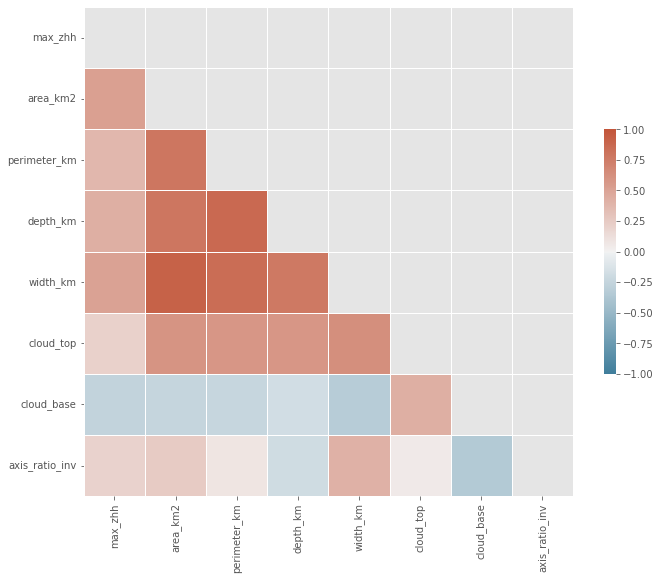

In [52]:
corr = df_subset.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,vmin=-1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [58]:
mean = df_day[['max_zhh', 'area_km2', 'perimeter_km', 'depth_km', 'width_km',
       'cloud_top', 'cloud_base', 'axis_ratio_inv', 'vuelo']].mean()

In [59]:
mean_corr = mean.corr()

<AxesSubplot:>

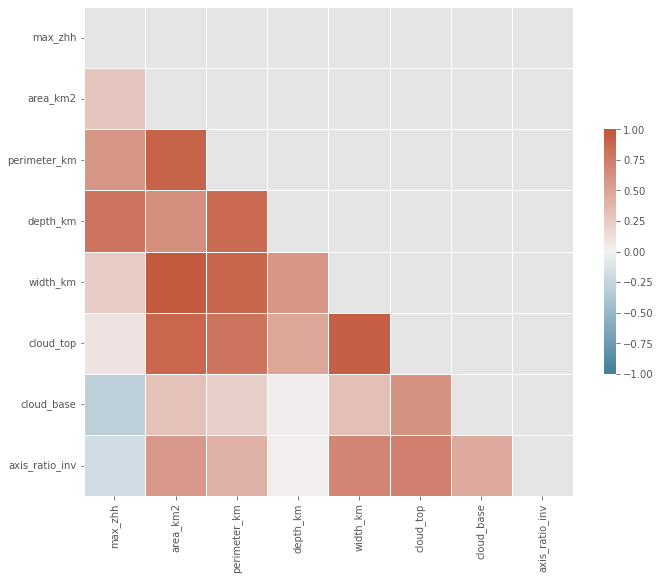

In [60]:
mask = np.triu(np.ones_like(mean_corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(mean_corr, mask=mask, cmap=cmap, vmax=1, center=0,vmin=-1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})